In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [2]:
#seeds:
np.random.seed(123)
tf.random.set_seed(123)

# Data Loading

In [3]:
artist_df = pd.read_csv('./Data/artists.csv', sep=",")
print("The number of painting is {}.".format(artist_df.shape[0]))

The number of painting is 50.


In [5]:
artist_df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [6]:
images_dir = './Data/resized'
artists_dirs = list(set([" ".join(filename.split("_")[:-1]) for filename in os.listdir(images_dir)])) #get all names from /resized
n_classes = len(artists_dirs)
print(artists_dirs)

['Amedeo Modigliani', 'William Turner', 'Gustave Courbet', 'Rembrandt', 'Sandro Botticelli', 'Edouard Manet', 'Albrecht Dürer', 'Marc Chagall', 'Paul Gauguin', 'Paul Klee', 'Diego Velazquez', 'Eugene Delacroix', 'Francisco Goya', 'Henri Matisse', 'Raphael', 'Andy Warhol', 'Salvador Dali', 'Henri Rousseau', 'Jan van Eyck', 'Giotto di Bondone', 'Claude Monet', 'Mikhail Vrubel', 'Diego Rivera', 'Vincent van Gogh', 'Hieronymus Bosch', 'El Greco', 'Leonardo da Vinci', 'Titian', 'Rene Magritte', 'Michelangelo', 'Pierre-Auguste Renoir', 'Frida Kahlo', 'Kazimir Malevich', 'Georges Seurat', 'Jackson Pollock', 'Alfred Sisley', 'Camille Pissarro', 'Vasiliy Kandinskiy', 'Albrecht Du╠êrer', 'Edvard Munch', 'Peter Paul Rubens', 'Caravaggio', 'Joan Miro', 'Pablo Picasso', 'Henri de Toulouse-Lautrec', 'Edgar Degas', 'Paul Cezanne', 'Piet Mondrian', 'Pieter Bruegel', 'Gustav Klimt', 'Andrei Rublev']


In [7]:
print(len(artists_dirs))

51


In [8]:
# Correct the data quality issue with Albrecht Dürer
artists_dirs.remove('Albrecht Du╠êrer')

In [9]:
print(len(artists_dirs))

50


# Data Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


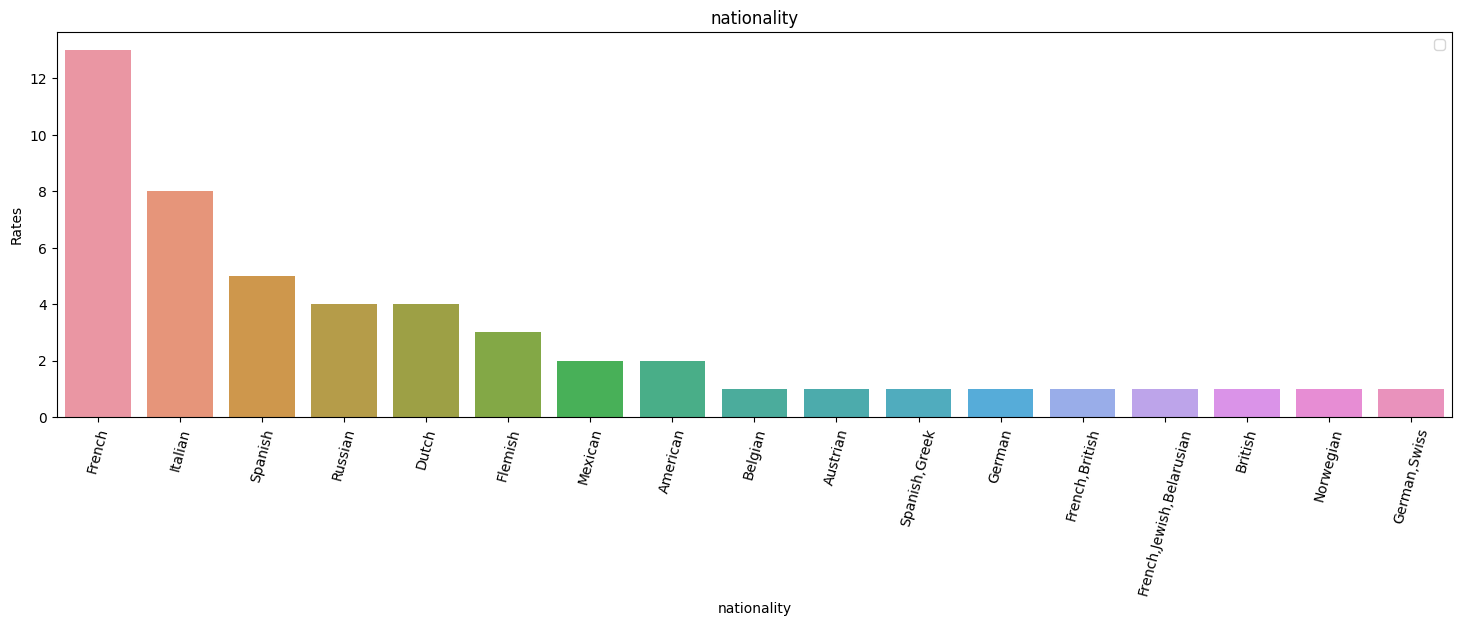

In [10]:
plt.figure(figsize=(18,5))

sns.barplot(x=artist_df['nationality'].value_counts().index,y=artist_df['nationality'].value_counts().values)
plt.title('nationality')
plt.xticks(rotation=75)
plt.ylabel('Rates')
plt.legend(loc=0)
plt.show()

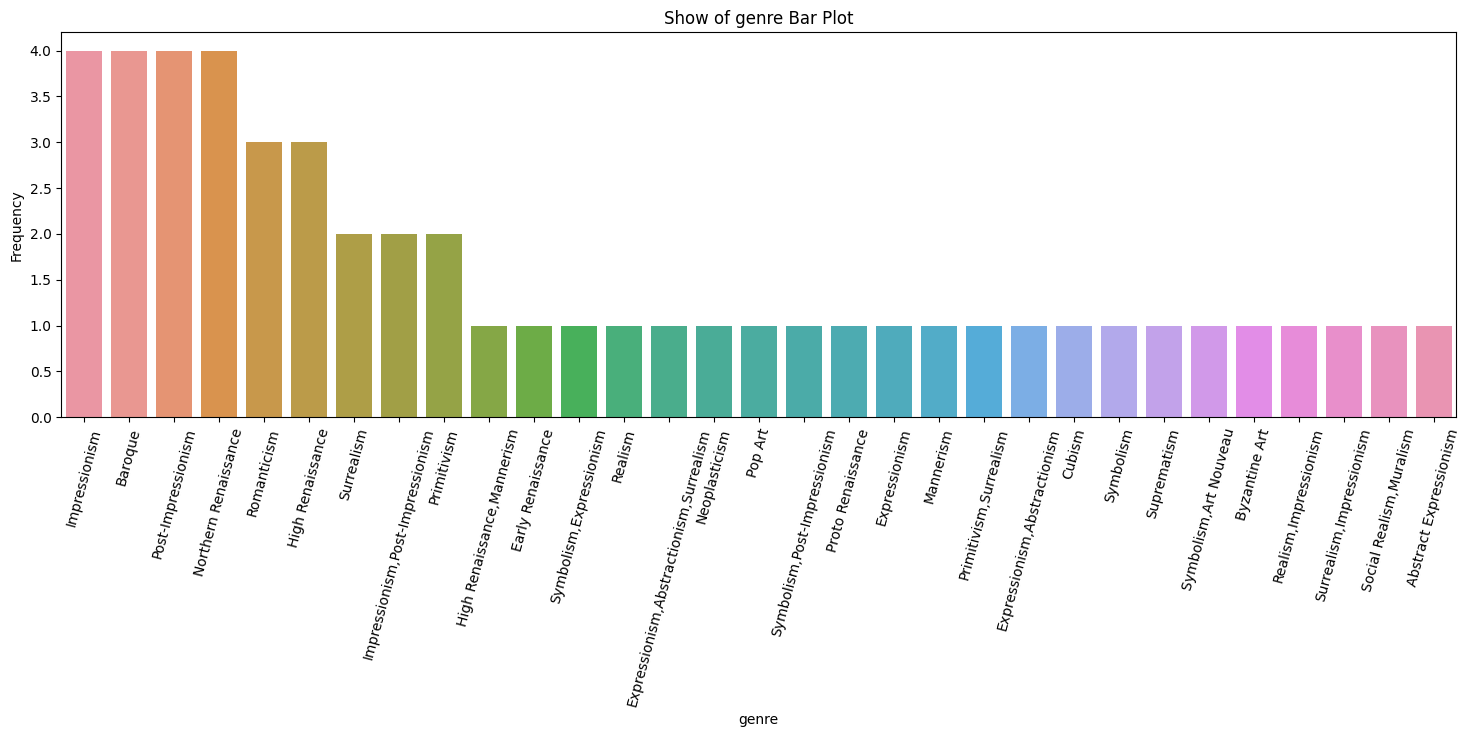

In [11]:
plt.figure(figsize=(18,5))
sns.barplot(x=artist_df['genre'].value_counts().index,
              y=artist_df['genre'].value_counts().values)
plt.xlabel('genre')
plt.xticks(rotation=75)
plt.ylabel('Frequency')
plt.title('Show of genre Bar Plot')
plt.show()

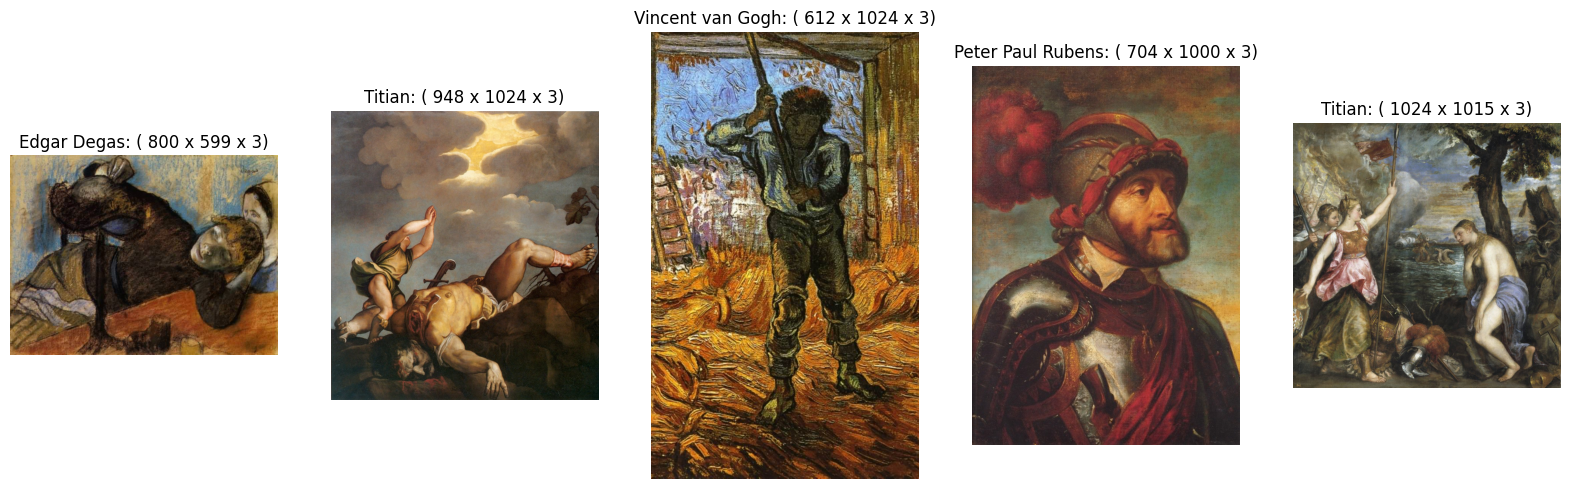

In [29]:
fig, axes = plt.subplots(1, 5, figsize=(20,10))

for i in range(5):
    random_image = random.choice(os.listdir(os.path.join(images_dir)))
    random_image_file = os.path.join(images_dir, random_image)
    image = plt.imread(random_image_file)
    
    # Get the shape of the image
    height, width, channels = image.shape
    artist_name = " ".join(random_image.split("_")[:-1])

    axes[i].imshow(image)
    axes[i].set_title(artist_name+ f": ( {width} x {height} x {channels})")
    axes[i].axis('off')

plt.show()

# Train and Test Split

In [50]:
# Create a DataFrame to store filename and artist mapping
file_artist_mapping = []

for filename in os.listdir(images_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        artist_name = " ".join(filename.split("_")[:-1])
        file_artist_mapping.append({'filename': filename, 'artist': artist_name})

df = pd.DataFrame(file_artist_mapping)

# Remove rows where the artist is 'Albrecht Du╠êrer'
df = df[df['artist'] != 'Albrecht Du╠êrer']

# Get unique artist names
artists = df['artist'].unique()
n_classes = len(artists)



# Define image size and other parameters
img_size = (128, 128)
batch_size = 32
train_input_shape = (128, 128, 3)

# Create data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_dir,
    x_col='filename',
    y_col='artist',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_dir,
    x_col='filename',
    y_col='artist',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 6757 validated image filenames belonging to 50 classes.
Found 1689 validated image filenames belonging to 50 classes.


# Simple CNN Model

In [51]:
def simple_cnn():
    
    # Build a simple CNN model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(n_classes, activation='softmax'))

    return model

In [53]:
#Initialize model
model= simple_cnn()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
212/212 [==============================] - 65s 307ms/step - loss: 3.6718 - accuracy: 0.1061 - val_loss: 3.4454 - val_accuracy: 0.1468
Epoch 2/10
212/212 [==============================] - 61s 288ms/step - loss: 3.4299 - accuracy: 0.1527 - val_loss: 3.3318 - val_accuracy: 0.1504
Epoch 3/10
212/212 [==============================] - 55s 261ms/step - loss: 3.3114 - accuracy: 0.1797 - val_loss: 3.2361 - val_accuracy: 0.1753
Epoch 4/10
212/212 [==============================] - 61s 288ms/step - loss: 3.2403 - accuracy: 0.2036 - val_loss: 3.1021 - val_accuracy: 0.2297
Epoch 5/10
212/212 [==============================] - 63s 298ms/step - loss: 3.2341 - accuracy: 0.2226 - val_loss: 3.0288 - val_accuracy: 0.2534
Epoch 6/10
212/212 [==============================] - 60s 280ms/step - loss: 3.1923 - accuracy: 0.2358 - val_loss: 3.0464 - val_accuracy: 0.2593
Epoch 7/10
212/212 [==============================] - 54s 256ms/step - loss: 3.1335 - accuracy: 0.2581 - val_loss: 3.0002 - val_ac

In [54]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

212/212 [==============================] - 45s 212ms/step - loss: 2.6615 - accuracy: 0.3725
Prediction accuracy on train data = 0.3725026249885559


In [55]:
# Prediction accuracy on CV data
score = model.evaluate_generator(validation_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

53/53 [==============================] - 11s 204ms/step - loss: 3.5903 - accuracy: 0.2463
Prediction accuracy on CV data = 0.2462995946407318


In [56]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 14, 14, 128)      

# Data Augmentation

In [57]:
# Create a data generator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_dir,
    x_col='filename',
    y_col='artist',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_dir,
    x_col='filename',
    y_col='artist',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 6757 validated image filenames belonging to 50 classes.
Found 1689 validated image filenames belonging to 50 classes.


In [58]:
model= simple_cnn()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
212/212 [==============================] - 71s 329ms/step - loss: 3.5890 - accuracy: 0.1221 - val_loss: 3.3704 - val_accuracy: 0.1581
Epoch 2/10
212/212 [==============================] - 68s 320ms/step - loss: 3.3054 - accuracy: 0.1816 - val_loss: 3.1677 - val_accuracy: 0.1966
Epoch 3/10
212/212 [==============================] - 64s 300ms/step - loss: 3.1696 - accuracy: 0.2072 - val_loss: 2.9831 - val_accuracy: 0.2303
Epoch 4/10
212/212 [==============================] - 67s 314ms/step - loss: 3.0607 - accuracy: 0.2389 - val_loss: 2.9412 - val_accuracy: 0.2427
Epoch 5/10
212/212 [==============================] - 65s 305ms/step - loss: 3.0881 - accuracy: 0.2437 - val_loss: 2.8675 - val_accuracy: 0.2587
Epoch 6/10
212/212 [==============================] - 64s 300ms/step - loss: 3.0239 - accuracy: 0.2578 - val_loss: 2.8938 - val_accuracy: 0.2605
Epoch 7/10
212/212 [==============================] - 63s 298ms/step - loss: 2.9631 - accuracy: 0.2688 - val_loss: 2.8860 - val_ac

In [59]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

212/212 [==============================] - 55s 260ms/step - loss: 2.5954 - accuracy: 0.3444
Prediction accuracy on train data = 0.3443836271762848


In [60]:
# Prediction accuracy on CV data
score = model.evaluate_generator(validation_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

53/53 [==============================] - 13s 244ms/step - loss: 3.0385 - accuracy: 0.2759
Prediction accuracy on CV data = 0.2759028971195221


In [61]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 14, 14, 128)      